In classical linear regression models, one of the assumptions we make is that the variance of disturbance(error) term is constant and this assumption is known as ***Homoscedasticity*** [ie. equal(homo) spread(scedasticity)].  

If $ \epsilon $ is the error term, then $ E(\epsilon_i^2) = \sigma^2$  where $\sigma$ is the standard deviation.

 The violation of this assumption is ***Heteroscedasticity***.  
 Some of the causes of Heteroscedasticity include,
*   Presence of outliers in the observations (stock prices)
*   Incorrect transformation of data used for the regression model
*   When regression model is itself wrongly specified
*   Skewness in distribution of regressor variables. For example, economic variables like income are unevenly distibuted  

Let's try to visualize all the above cases for better clarity.   
Firstly, we will try plotting a dataset containing random outliers.





In [24]:
#importing required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm,f
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

%matplotlib inline


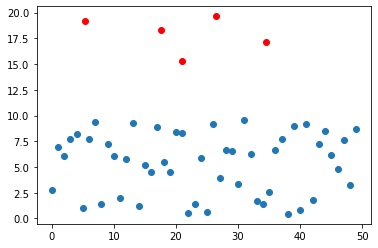

In [6]:
'''Outliers'''
#generating random observations for 0 to 10
normal_data = np.random.uniform(low = 0, high = 10, size = 50)

#generating outliers
outliers = np.random.uniform(low = 15, high = 20, size = 5)

#plotting 
plt.scatter(range(len(normal_data)),normal_data)
plt.scatter(np.random.uniform(low = 0, high = 50, size = 5), outliers, c='r')

In the above plot, we see that the outliers(in red) vary largely from the rest of the observations and thus cause heteroscadasticity.   




Next, let's see how incorrect transformation of data might cause heteroscedasticity.


In [8]:
#generating a random sample for the independent variable x
x = np.sort(np.random.uniform(low = 0, high = 200, size = 200))
#storing the log values of x in another variable
log_x = np.log(x)

#generating the error term 
u = 0.5 * np.random.rand(200) 

#generating the dependent variable y using a arbitrary expression
log_y = log_x + u
y = np.exp(log_y)

We have generated a sample where log(y) and log(x) have a linear relation, that is $ \log(y) = \log(x) + \epsilon$.   
So,  x and y should have a linear relation! Let's try plotting the relation between $x$ and $y$.

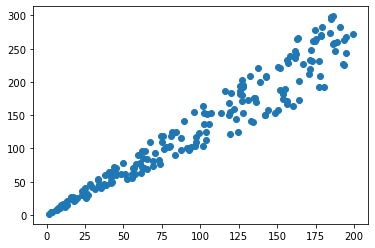

In [9]:
plt.scatter(x,y)

Suprisingnly, we find that the $y$ values become more spread out as $x$ increases. This clearly indicates heteroscedasticity.  
In the next plot, see that when we plot $\log(y)$ vs $x$ there isn't much effect of heteroscedasticity.

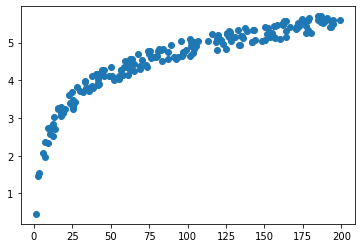

In [10]:
plt.scatter(x,log_y)

Now as it is clear that an incorrect transformation of variable might cause heteroscedasticity, let's move to the next case.  
Here we will generate a example of how a wrongly specified model causes heteroscedasticity.

In [11]:
#generating samples for two independent variables from a random distribution
x1 = np.random.uniform(low = 0, high = 50, size = 200)
x2 = np.random.uniform(low = 0, high = 100, size = 200)

#defining the dependent variable by a arbitrary expression
y = 1.5*x1 + 5*x2 + 3


Now forget that we already know the relation between y and x [x1 and x2].   

We will assume that $y$ is dependent only on $x_2$ and fit a OLS regression model.   
After fitting, we will also plot the residuals(errors) against $x_1$ to find out if the residuals are homoscedastic.

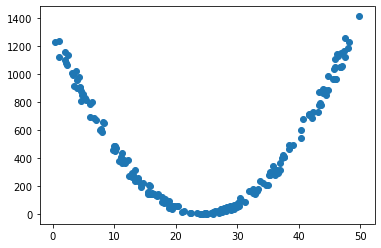

In [12]:
#regressing for y against x2
x2_model = sm.OLS(y,sm.add_constant(x2)).fit()

#extracting residual values from the fitted model
residuals = x2_model.resid

#plotting squared residuals against x1
plt.scatter(x1,residuals**2)

The above plot shows that the errors vary hugely in a U-shaped manner, indicating that the current model is not a good predictors for extreme values of $x_1$.   
Thus, it is clear that a *incorrectly specified model* could cause heteroscedasticity.   

Nextly, let's visualise a skewed distribution which could also cause heteroscedasticity.

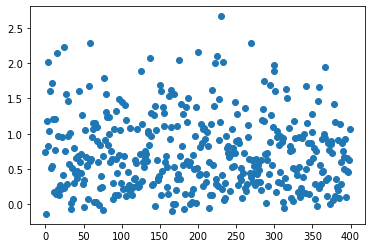

In [13]:
skewedDist = skewnorm.rvs(a = 15, size= 400)
plt.scatter(range(len(skewedDist)), skewedDist)

Try to think of the above as an income distribution. Very few people tend to have higher incomes while a large number of people have low incomes. Thus, we tend to have fewer samples of higher incomes which translates into larger errors for high income samples when income is used as a regressor variable.

In the presence of heteroscedasticity, the estimators are no longer efficient and hypothesis tests(like t-test, F-test) become invalid. So, it is essential to detect heteroscedasticity and adjust for it.   
Firstly, let's create a heteroscedastic dataset and plot it to see how it looks like!

In [14]:
#setting sample size
size = 200

#generating a random sample for the independent variable x
x = np.sort(np.random.uniform(low = 0, high = 50, size = size))

#generating the error term which increases with increasing values of x
u = 1.5* np.random.rand(size) * x

#generating the dependent variable y using a arbitrary expression
y = 5 + 1.1*x + u

Text(0, 0.5, 'y')

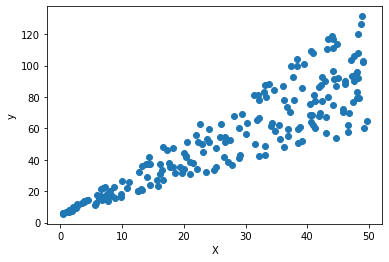

In [15]:
#ploting the data
plt.scatter(x,y)
plt.xlabel('X')
plt.ylabel('y')

We can clearly see that the y value varies a lot for larger values of x  
Although we now detected heteroscedasticity by visualising the data, there are some standard statistical tests to detect heteroscedasticity.  
We will now use the functions from [statsmodels](https://www.statsmodels.org/dev/diagnostic.html) library to perform *Breusch-Pagan test* and *Goldfeld-Quandt test*.

In [16]:
'''Breusch-Pagan test'''
#performing OLS fit as residual values are needed for Breusch-Pagan test
model = sm.OLS(y,sm.add_constant(x)).fit()

#extracting residual values from the fitted model
residuals = model.resid

#performing Breusch-Pagan test
bp_test = het_breuschpagan(residuals, x.reshape(-1,1))

#zipping and printing the results 
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))


{'LM Statistic': 93.95645185492141, 'LM-Test p-value': nan, 'F-Statistic': 176.31750583778526, 'F-Test p-value': 3.139151641745118e-29}


We have got two test statistics and the p-values (F-test is widely used but both are basically equivalent).  
If p-value is less than 0.05, we reject the null hypothesis of homoscedasticity (i.e. it indicates heteroscedasticity). As we get both p-values <0.05, this model is heteroscedastic.


We will perform the Breusch-Pagan test manually and calculate the F-statistic again.      

With BP test, we try to find if the residuals are dependent on $x$.

In [32]:
#calculating squared residuals and normalizing 
sq_residuals = residuals ** 2
sq_residuals = sq_residuals / np.mean(sq_residuals)

#extracting no. of observations and variables using np.shape() function
n_obs, n_vars = np.shape(x.reshape(-1,1))

#fitting an OLS model for squared residuals vs X
ols = sm.OLS(sq_residuals, x.reshape(-1,1)).fit()

#F-statistic of the hypothesis that the error variance depends on X
fval = ols.fvalue
#p-value corresponding to the hypothesis
pval = ols.f_pvalue

print("F-Statistic: ",fval,", p-value: " ,pval)

F-Statistic:  176.3175058377853 , p-value:  3.1391516417450524e-29


We have got similar results!!        

We will now move on to Goldfeld-Quandt test.

In [17]:
'''Goldfeld-Quandt test'''
gq_test = het_goldfeldquandt(y,x.reshape(-1,1))
print("F-Statistic: ",gq_test[0],", p-value: " ,gq_test[1])

F-Statistic:  5.836933472376832 , p-value:  6.682442801540943e-17


Let's recreate Goldfeld-Quandt test manually for better understanding.   

Goldfeld-Quandt test verifies if the residual variance is same in two sample subsets.   
We will divide the dataset into halves, fit separate OLS models for both and then see if the residuals in both models differ greatly.

In [30]:
#extracting no. of observations and variables using np.shape() function
n_obs, n_vars = np.shape(x.reshape(-1,1))
#obtaining the middle index to split the dataset
split = n_obs//2

#fitting separate OLS models to each half
ols1 = sm.OLS(y[:split], x[:split]).fit()
ols2 = sm.OLS(y[split:], x[split:]).fit()

#value of F-statistic that the variance in one subsample is larger than in the other subsample
fval = ols2.mse_resid / ols1.mse_resid
#p-value corresponding to the hypothesis
pval = f.sf(fval, ols1.df_resid, ols2.df_resid)

print("F-Statistic: ",fval,", p-value: " ,pval)

F-Statistic:  5.836933472376832 , p-value:  6.682442801540943e-17


We get the same result as the earlier function call!     
So, as with the previous test we reject the null hypothesis as p-value comes out to be less than 0.05.  

Now that we have detected heteroscedasticity, we have to deal with it!  

We can dampen the effect of heteroscedasticity to some extent by applying log transformation to 'y'. In the below plot, note that the error becomes almost constant terminally.



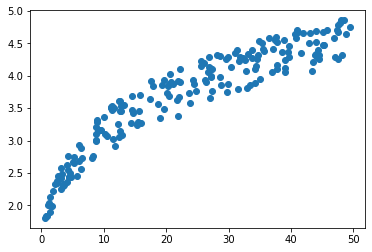

In [6]:
#Log-transforming y 
plt.scatter(x,np.log(y))

But in many cases heteroscedasticity may still persist after transformation and so,we cannot fit models which assume homoscedaticity.  
There are some generalized regression models like *Weighted Least Squares*(WLS) or *Generalized Least Squares*(GLS) - which don't assume homoscedastic variance.  

Using WLS, the weight for each datapoint can be scaled inversely with the variance. But then we have to model variance as a function of x!      
For the current dataset, we know that variance increases for higher values of x. So we can define the weights as inverse of x values.




In [7]:
'''Fitting a WLS model'''
#Performing WLS fit with weights varying as inverse of x
mod_wls = sm.WLS(y,sm.add_constant(x),weights = 1./x).fit()


Now let's plot the WLS and OLS results to see the difference

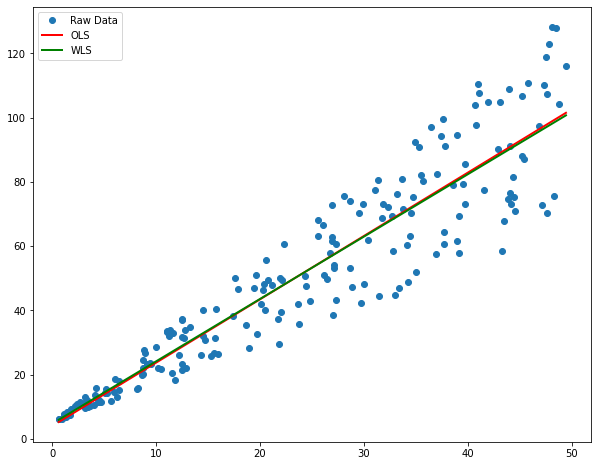

In [8]:
#plotting the regression lines
plt.subplots(figsize=(10,8))
plt.plot(x,y,'o',label = "Raw Data")
plt.plot(x,model.fittedvalues,'r',label = "OLS",linewidth = 2)
plt.plot(x,mod_wls.fittedvalues,'g',label = "WLS",linewidth = 2)
plt.legend()

Although there's only a slight difference here, in real world applications a small change in slope might make a lot of impact.

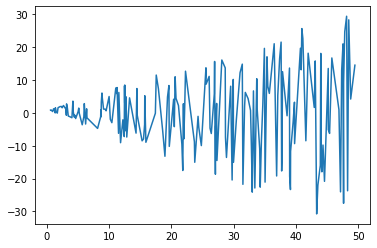

In [11]:
plt.plot(x,residuals)